# (text, {(5, 12): ((i[关注位置],j【被关注位置】) ,(src_id, tgt_id), value), (7, 9): xx})
# (text, {(5, 12): xx, (7, 9): xx})

In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import sys
import os

sys.path.insert(0, '/nas/xd/projects/transformers/src')
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import random
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, AutoModelForCausalLM

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, GPTJForCausalLM
import pysvelte as ps 
import unseal
import string
from itertools import product, chain
import math
import json
from IPython.display import HTML, display

import torch
from unseal import transformers_util as tutil
from unseal import hooks
import unseal.visuals.utils as utils
from unseal.hooks import HookedModel



from utils import *
from child_utils import *
from common_utils import *
from model_utils import *
from weight_analysis import *

In file_utils.py: default_cache_path = /raid/xd/.cache/torch/hub
Loading tokenizer ... done 0:00:10.163072


In [3]:
from utils_nrk import *
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "last_expr"

# 载入模型

In [5]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry

proxies = {'http': '192.168.50.1:1081'} 
model_name = "EleutherAI/gpt-j-6B"

# model_name = "EleutherAI/gpt-neo-1.3B"
model = GPTJForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
# model = AutoModelForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

In [54]:
print(1)

Loading tokenizer ... done 0:00:08.797830


[autoreload of const failed: Traceback (most recent call last):
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/nas/xd/projects/transformers/notebooks/const.py", line 10, in <module>
    with Timer('Loading tokenizer'): 

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
  

# 运行流程

# 运行部分

In [53]:
x = torch.randn(5, 5) #随机生成一个二维Tensor
x = x[2:].detach().numpy()
for i in range(len(x)):
    x[i][0] = 0 
x = torch.tensor(x)
a = (x==torch.max(x)).nonzero()
a = torch.squeeze(a,0)
print(x[a[0]][a[1]])

tensor([[ 0.2827, -0.0876,  0.2769, -0.6342,  0.5479],
        [ 1.7191,  0.0124, -0.6078, -1.0990,  0.6931],
        [ 1.9942, -0.0683,  0.4292,  0.7143, -1.9729],
        [-0.2325, -1.0305, -0.4197,  0.1274,  0.2445],
        [ 0.5652, -1.3063, -0.4229, -1.8184, -1.2754]])
[[ 0.         -0.06828743  0.42916936  0.71429616 -1.9728798 ]
 [ 0.         -1.030457   -0.41968152  0.12735125  0.24452062]
 [ 0.         -1.3063049  -0.42292908 -1.8184334  -1.2754133 ]]
tensor([0, 3])
tensor(0.7143)


In [13]:
heads = [(5,12), (7,9) , (7,2) , (6,5) , (3,7) , (8,7) , (6,2) , (3,12)]
head_list = load_list("1")
rate = show_rate(head_list, heads)
rate

数据量： 1267


,出现次数,出现频率
"(5, 12)",551,0.434886
"(7, 9)",692,0.546172
"(7, 2)",720,0.568272
"(6, 5)",874,0.689818
"(3, 7)",997,0.786898
"(8, 7)",1041,0.821626
"(6, 2)",1060,0.836622
"(3, 12)",1248,0.985004


In [23]:
distence = show_loc(head_list, (7, 2)) #取最大的概率值的关注位置
distence

,被关注token,关注token,关注距离
0,",",Ġruined,6
1,Ġwatch,Ġup,5
2,Ġto,Ġresponsible,7
3,Ġwhen,Ġhouse,11
4,Ġwhen,Ġhouse,11
...,...,...,...
687,Ġto,Ġvery,6
688,Ġback,Ġpassenger,4
689,.,Ġtried,7
690,oise,Ġgift,7


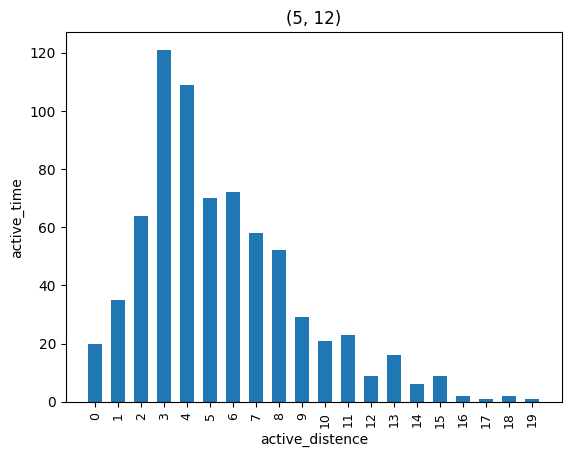

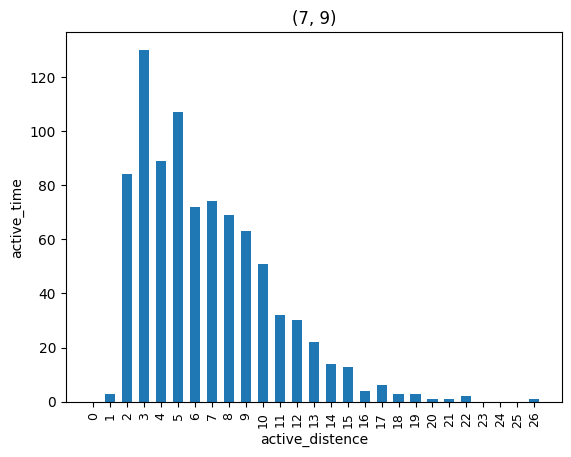

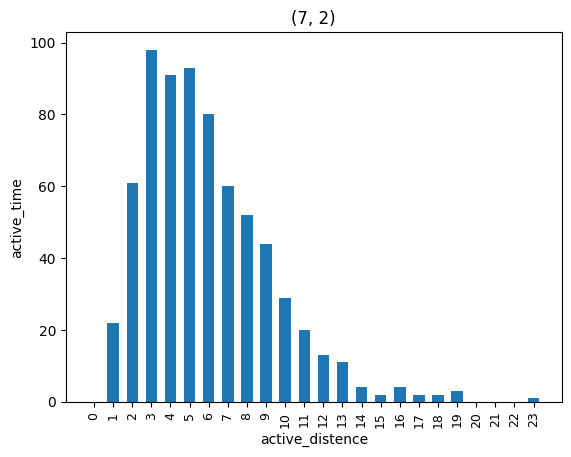

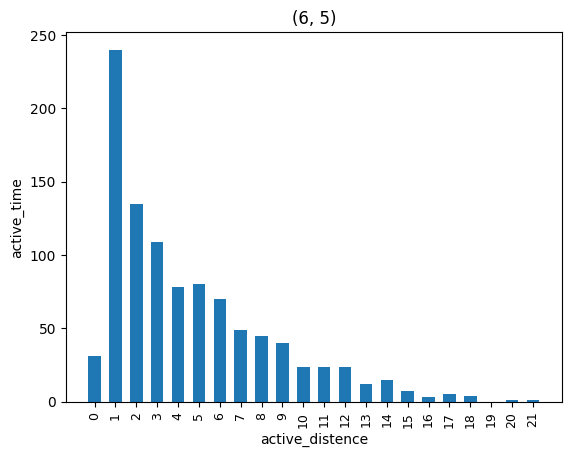

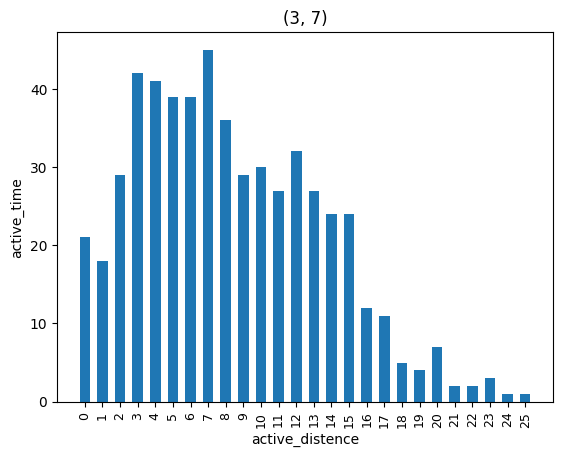

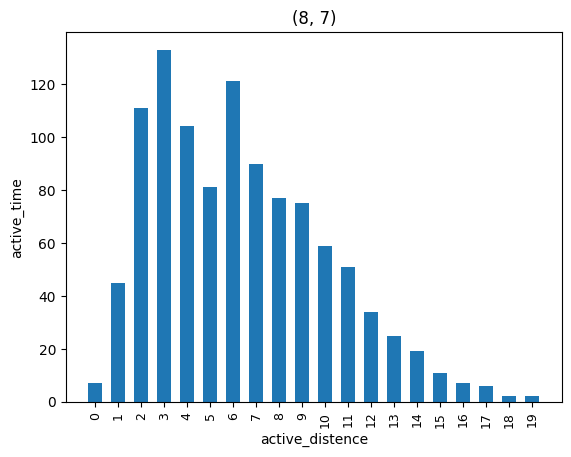

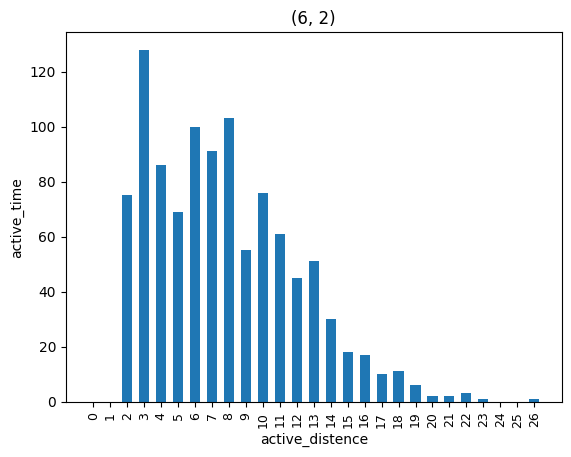

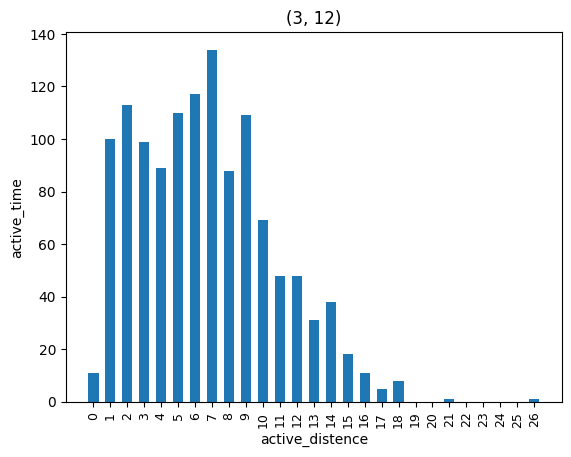

In [11]:
show_times_distence(head_list, heads)

In [61]:
head_list = load_list("1")
dis,data = count_distence(head_list, (5,12))
only_count_distence(dis)

[ 20.  35.  64. 121. 109.  70.  72.  58.  52.  29.  21.  23.   9.  16.
   6.   9.   2.   1.   2.   1.]


In [22]:
heads = [(5,12), (7,9) , (7,2) , (6,5) , (3,7) , (8,7) , (6,2) , (3,12)]

head_list = load_list("1")
show_activations(model, tokenizer, head_list, heads, 5)

In [21]:
# import npm
# from contextlib import suppress
# from typing import Optional
# import random
# import pysvelte as ps 
# heads = [(5, 12), (7, 9)]

# texts = read_texts("5")
# head_dict = find_activations(model, tokenizer, texts, heads)
# dump_dict(head_dict)
# head_dict = load_dict()
# show_activations(model, tokenizer, head_dict, heads, 5)

In [42]:
text = "Avery was debating on taking up German instead of Latin, because the Latin was old."
sent = tokenizer.tokenize(text)

In [52]:
tokenized_text = list(map(tokenizer.convert_tokens_to_string, map(lambda x: x, sent))) 
print(tokenized_text)

['A', 'very', ' was', ' debating', ' on', ' taking', ' up', ' German', ' instead', ' of', ' Latin', ',', ' because', ' the', ' Latin', ' was', ' old', '.']


In [51]:
a = list(map(lambda x: x, sent))
print(a)

['A', 'very', 'Ġwas', 'Ġdebating', 'Ġon', 'Ġtaking', 'Ġup', 'ĠGerman', 'Ġinstead', 'Ġof', 'ĠLatin', ',', 'Ġbecause', 'Ġthe', 'ĠLatin', 'Ġwas', 'Ġold', '.']
